In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from scipy.ndimage import zoom
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import ast
from itertools import combinations
from itertools import chain

import sys
sys.path.append("../")
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import nibabel as nb
import matplotlib.pyplot as plt
import functions_collection as ff
import Data_processing as dp

main_path = '/mnt/camca_NAS/Deepstrain/results'
patinet_info = pd.read_excel('/mnt/camca_NAS/SAM_for_CMR/data/Patient_list/HFpEF_fulldataset_basic_info_edited.xlsx')

In [3]:
def stratified_even_split(num_patients, label0_indices, label1_indices, num_groups=5):
    # Shuffle the indices for random distribution
    np.random.shuffle(label0_indices)
    np.random.shuffle(label1_indices)
    
    # Initialize empty groups
    groups = [[] for _ in range(num_groups)]
    
    # Distribute label 1 patients across groups evenly
    for i, idx in enumerate(label1_indices):
        groups[i % num_groups].append(idx)
    
    # Distribute label 0 patients across groups evenly
    for i, idx in enumerate(label0_indices):
        groups[i % num_groups].append(idx)
    
    # Balance total patient count in each group by redistributing if needed
    group_sizes = [len(group) for group in groups]
    while max(group_sizes) - min(group_sizes) > 1:
        # Find the group with the most patients and the group with the fewest
        max_group = group_sizes.index(max(group_sizes))
        min_group = group_sizes.index(min(group_sizes))
        
        # Move a patient from the largest group to the smallest group
        patient_to_move = groups[max_group].pop()
        groups[min_group].append(patient_to_move)
        
        # Recalculate group sizes
        group_sizes = [len(group) for group in groups]

    return groups

## Understand the labels in this dataset

In [5]:
from datetime import datetime
label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
label_list = []
# counts
count_0 = 0
count_1_no_surgery = 0
count_1_surgery_no_readmission = 0
count_1_surgery_readmission = 0
count_1_readmission_in_one_year = 0
count_1_readmission_larger_than_one_year = 0

for i in range(0, label_sheet.shape[0]):
    label = label_sheet.iloc[i, 1]
    if '0.5' in str(label):
        l = int(label[0])
        initial_l = l
    else:
        l = int(label)
        initial_l = l
    
    # readmission larger than one year
    if l == 1:
        readmission_date = int(label_sheet.iloc[i, 3])
        study_date = int(label_sheet.iloc[i]['StudyDate'])
       
        readmission_date = datetime.strptime(str(readmission_date), "%Y%m%d")
        study_date = datetime.strptime(str(study_date), "%Y%m%d")

        # calculate the time difference
        time_diff = (readmission_date - study_date).days
        if time_diff >= 366:
            # print('readmission_date:', readmission_date, ' study_date:', study_date, ' time_diff:', time_diff)
            l = 1
    
    # consider surgery also as readmission
    if l == 0:
        surgery = label_sheet.iloc[i, 4]
        if surgery == 1:
            l = 1
    
    # count
    if l == 0:
        count_0 += 1
    if l == 1:
        if time_diff < 366:
            count_1_readmission_in_one_year += 1
        else:
            count_1_readmission_larger_than_one_year += 1

        surgery = label_sheet.iloc[i, 4]
        if surgery == 0:
            count_1_no_surgery += 1
        if surgery == 1:
            if initial_l == 1:
                count_1_surgery_readmission += 1
            else:
                count_1_surgery_no_readmission += 1

    label_list.append(l)
label_list = np.asarray(label_list)

print('count_0:', count_0)
print('count_1_no_surgery:', count_1_no_surgery)
print('count_1_surgery_no_readmission:', count_1_surgery_no_readmission)
print('count_1_surgery_readmission:', count_1_surgery_readmission)
print('count_1_readmission_in_one_year:', count_1_readmission_in_one_year)
print('count_1_readmission_larger_than_one_year:', count_1_readmission_larger_than_one_year)

count_0: 94
count_1_no_surgery: 30
count_1_surgery_no_readmission: 5
count_1_surgery_readmission: 7
count_1_readmission_in_one_year: 33
count_1_readmission_larger_than_one_year: 9


### Process the temporal strain

In [ ]:
# get 25-time-frame strain and get correlation matrix
def correlation_matrix_cal(patient_id):

    folders = ff.sort_timeframe(ff.find_all_target_files(['tf_*'],os.path.join(main_path,'strain',patient_id)), 0,'_','')
    Ecc_aha_ori = np.zeros((len(folders),16))
    Err_aha_ori = np.zeros((len(folders),16))
    for i in range(len(folders)):
        strain_file = np.load(os.path.join(main_path,'strain',patient_id,folders[i],'strain_info.npy'),allow_pickle=True)
        ecc_aha = np.asarray(strain_file[-2][:-1] )
        err_aha = np.asarray(strain_file[-1][:-1] )
        Ecc_aha_ori[i] = ecc_aha
        Err_aha_ori[i] = err_aha

    Ecc_aha = np.zeros((16, len(folders))); Err_aha = np.zeros((16, len(folders)))
    for i in range(0,16):
        for j in range(len(folders)):
            Ecc_aha[i,j] = Ecc_aha_ori[j,i]
            Err_aha[i,j] = Err_aha_ori[j,i]

    # sample 25 time frames
    row_in_info = patinet_info[patinet_info['patient_id'] == patient_id]
    t_original = ast.literal_eval(row_in_info['processed_time_frame_index_list'].values[0])
    t_original = [int(i) for i in t_original]; t_original = np.asarray(t_original)
    if t_original[0] !=0:
        tt = []
        for j in range(0, len(t_original)):
            a = t_original[j] - t_original[0]
            if a < 0:
                a = t_original[j] - t_original[0] + 25
            tt.append(a)
        t_original = np.asarray(tt)
            
    t_new = np.arange(0, 25)

    Ecc_aha_sample = np.zeros((16,25))
    Err_aha_sample = np.zeros((16,25))
    print(t_original, Ecc_aha.shape)

    for i in range(16):
        spl_ecc = make_interp_spline(t_original, Ecc_aha[i,:], k=2)  # k=3表示三次样条
        ecc_new = spl_ecc(t_new)

        spl_err = make_interp_spline(t_original, Err_aha[i,:], k=2)  # k=3表示三次样条
        err_new = spl_err(t_new)

        Ecc_aha_sample[i] = ecc_new
        Err_aha_sample[i] = err_new

    correlation_matrix_Ecc = np.corrcoef(Err_aha_sample)
    correlation_matrix_Err = np.corrcoef(Ecc_aha_sample)
    return correlation_matrix_Ecc, correlation_matrix_Err, Ecc_aha_sample, Err_aha_sample

In [ ]:
# do it for each patient
label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
# for i in range(0, label_sheet.shape[0]):
#     patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    
#     print(i, patient_id)
        
#     correlation_matrix_Ecc, correlation_matrix_Err, Ecc_aha_sample, Err_aha_sample = correlation_matrix_cal(patient_id)
#     # np.save(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Ecc.npy'), correlation_matrix_Ecc)
#     # np.save(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Err.npy'), correlation_matrix_Err)
#     np.save(os.path.join(main_path, 'strain', patient_id, 'Ecc_aha_sample.npy'), Ecc_aha_sample)
#     np.save(os.path.join(main_path, 'strain', patient_id, 'Err_aha_sample.npy'), Err_aha_sample)
   

## Visualization of the strain results

ID_1207
max_value: 0.375473092614282 min_value: -0.1288722273089803


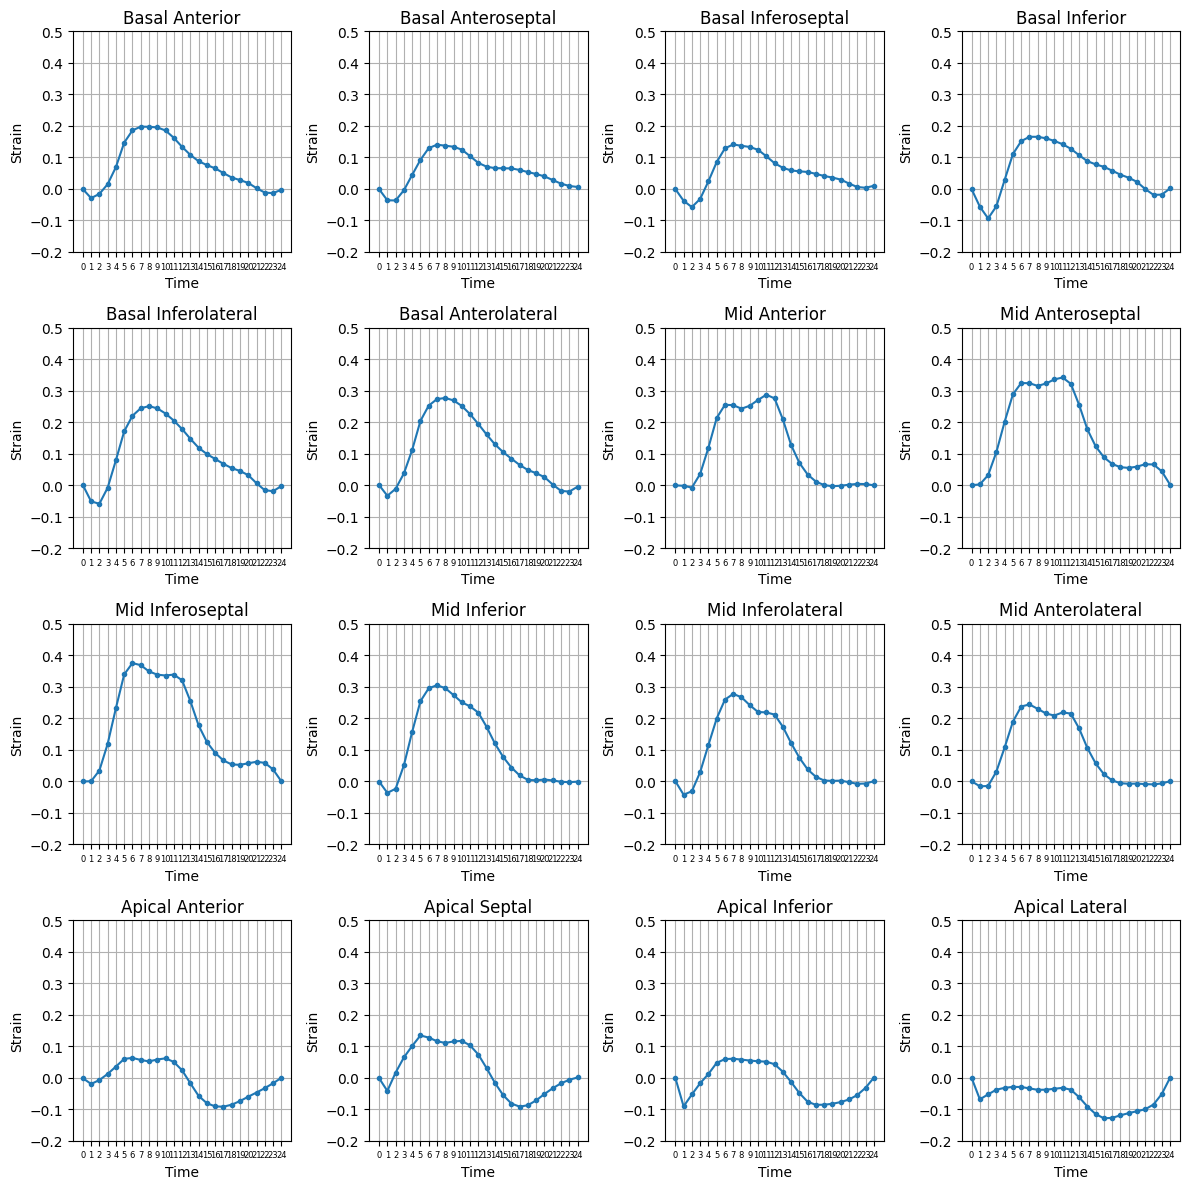

In [40]:
### visualize strain
label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
for i in range(3, 4):#label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    print(patient_id)

    Ecc_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Ecc_aha_sample.npy'))
    Err_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Err_aha_sample.npy'))
    correlation_matrix_Ecc = np.corrcoef(Err_aha_sample)
    correlation_matrix_Err = np.corrcoef(Ecc_aha_sample)

    data = Err_aha_sample

    # Define the segment names for the AHA 16 segments
    segment_names = [
        'Basal Anterior','Basal Anteroseptal','Basal Inferoseptal','Basal Inferior','Basal Inferolateral','Basal Anterolateral',
        'Mid Anterior','Mid Anteroseptal','Mid Inferoseptal','Mid Inferior','Mid Inferolateral','Mid Anterolateral',
        'Apical Anterior','Apical Septal','Apical Inferior','Apical Lateral']

    # Time points from 0 to 15 (total 16 points, but since your data has 15 observations, use 0 to 14)
    time_points = np.arange(25)

    # find the max and min value in data
    max_value = np.max(data)
    min_value = np.min(data)
    print('max_value:', max_value, 'min_value:', min_value)
    ytick_values = np.arange(np.round(min_value - 0.1,1), np.round(max_value + 0.2,1), 0.1)
    
    # Create a 4x4 grid of plots
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(16):
        axes[i].plot(time_points, data[i, :], marker='o', markersize = 3)
        axes[i].set_title(segment_names[i])
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Strain')
        axes[i].grid(True)
        axes[i].set_ylim(np.min(ytick_values), np.max(ytick_values))
        # axes[i].set_ylim(-0.10,0.50)
        axes[i].set_yticks(ytick_values)
        axes[i].set_xticks(time_points,fontsize=1)
        axes[i].set_xticklabels(time_points, fontsize=6)
        

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


the min for all dataset: correlation_Ecc_min: -0.9820219095494221  correlation_Err_min: -0.16576131033406


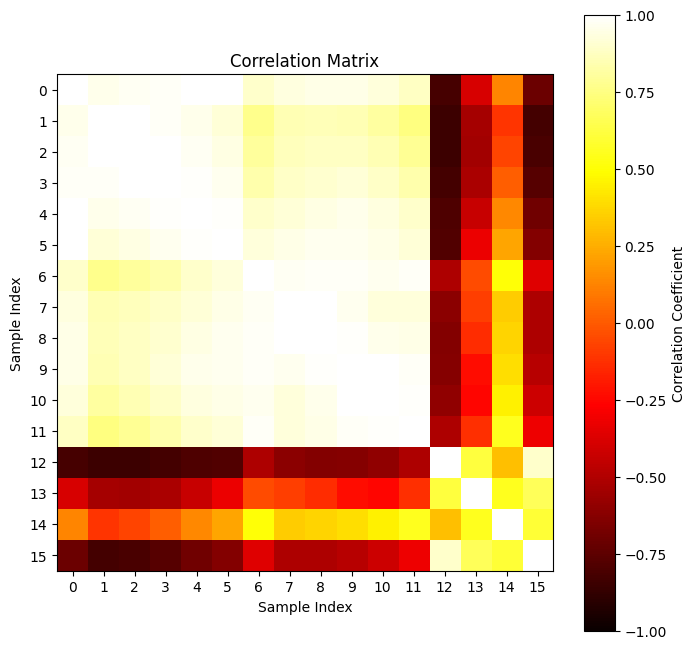

In [53]:
### visualize correlation
# first we need to know the range of correlation matrix

label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
correlation_Ecc_min_list = []
correlation_Err_min_list = []
for i in range(0,label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])

    Ecc_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Ecc_aha_sample.npy'))
    Err_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Err_aha_sample.npy'))
    correlation_matrix_Ecc = np.corrcoef(Err_aha_sample)
    correlation_matrix_Err = np.corrcoef(Ecc_aha_sample)
    correlation_Ecc_min = np.min(correlation_matrix_Ecc); correlation_Ecc_min_list.append(correlation_Ecc_min)
    correlation_Err_min = np.min(correlation_matrix_Err); correlation_Err_min_list.append(correlation_Err_min)

    # print('patient_id:', patient_id, ' correlation_Ecc_min:', correlation_Ecc_min, ' correlation_Err_min:', correlation_Err_min)
print('the min for all dataset: correlation_Ecc_min:', np.min(correlation_Ecc_min_list), ' correlation_Err_min:', np.min(correlation_Err_min_list))

# then plot 
for i in range(6,7):#label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])

    Ecc_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Ecc_aha_sample.npy'))
    Err_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Err_aha_sample.npy'))
    correlation_matrix_Ecc = np.corrcoef(Err_aha_sample)
    correlation_matrix_Err = np.corrcoef(Ecc_aha_sample)

    correlation_matrix = correlation_matrix_Ecc
    vmin = -1.0
    vmax = 1.0
    plt.figure(figsize=(8, 8))
    img = plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest', vmin = vmin, vmax = vmax)  # Fix color range
    cbar = plt.colorbar(img)
    cbar.set_label('Correlation Coefficient')
    
    # Title and axis labels
    plt.title('Correlation Matrix')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')

    # Set x and y ticks
    plt.xticks(range(16))
    plt.yticks(range(16))

    plt.show()


### evaluate simple GLS first

In [10]:
from datetime import datetime
label_sheet = pd.read_excel('/mnt/camca_NAS/HFpEF/data/HFpEF_data/Patient_list/re-admission-info/HFpEF_readmission_list_finalized.xlsx')
label_list = []
for i in range(0, label_sheet.shape[0]):
    label = label_sheet.iloc[i, 1]
    if '0.5' in str(label):
        l = int(label[0])
    else:
        l = int(label)
    
    # readmission larger than one year
    if l == 1:
        readmission_date = int(label_sheet.iloc[i, 3])
        study_date = int(label_sheet.iloc[i]['StudyDate'])
       
        readmission_date = datetime.strptime(str(readmission_date), "%Y%m%d")
        study_date = datetime.strptime(str(study_date), "%Y%m%d")

        # calculate the time difference
        time_diff = (readmission_date - study_date).days
        if time_diff >= 366:
            print('readmission_date:', readmission_date, ' study_date:', study_date, ' time_diff:', time_diff)
            l = 1
    
    # count surgery
    if l == 0:
        surgery = label_sheet.iloc[i, 4]
        if surgery == 1:
            l = 1

    label_list.append(l)
label_list = np.asarray(label_list)

readmission_date: 2019-03-24 00:00:00  study_date: 2017-08-23 00:00:00  time_diff: 578
readmission_date: 2018-10-24 00:00:00  study_date: 2017-03-21 00:00:00  time_diff: 582
readmission_date: 2018-10-04 00:00:00  study_date: 2016-11-25 00:00:00  time_diff: 678
readmission_date: 2018-08-02 00:00:00  study_date: 2016-11-10 00:00:00  time_diff: 630
readmission_date: 2018-06-13 00:00:00  study_date: 2016-10-07 00:00:00  time_diff: 614
readmission_date: 2017-09-18 00:00:00  study_date: 2016-05-05 00:00:00  time_diff: 501
readmission_date: 2017-03-20 00:00:00  study_date: 2015-07-24 00:00:00  time_diff: 605
readmission_date: 2016-12-21 00:00:00  study_date: 2015-06-09 00:00:00  time_diff: 561
readmission_date: 2016-05-02 00:00:00  study_date: 2015-03-24 00:00:00  time_diff: 405


In [11]:
# GLS
gls_list = []
for i in range(0, label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    file = os.path.join(main_path, 'strain', patient_id, 'gls.npy')
    f = np.load(file)
    gls = f[-1]
    gls_list.append(gls)
gls_list = np.asarray(gls_list)

In [12]:
label_0_group = np.where(label_list == 0)[0]
label_1_group = np.where(label_list == 1)[0]
print('label 0:', len(label_0_group), ' label 1:', len(label_1_group))

gls_0 = gls_list[label_0_group]
gls_1 = gls_list[label_1_group]

# found out whether gls_0 is significantly different from gls_1
from scipy.stats import ttest_ind
t, p = ttest_ind(gls_0, gls_1)
print(t, p)

label 0: 94  label 1: 42
0.4063931209448106 0.6851020716835795


In [13]:
gls_0_mean = np.mean(gls_0)
gls_1_mean = np.mean(gls_1)
print('gls_0_mean:', gls_0_mean, ' gls_1_mean:', gls_1_mean)

gls_0_mean: -0.262000980569946  gls_1_mean: -0.2680157313250636


## Prepare for the ML

### split dataset

In [14]:
# # Example usage
num_patients = 136
label0_indices = list(label_0_group)         # Example indices for label 0 patients
label1_indices = list(label_1_group)    # Example indices for label 1 patients

# # Get the split groups
# groups = stratified_even_split(num_patients, label0_indices, label1_indices)

# # Display the results
# for i, group in enumerate(groups):
#     print(f"Group {i + 1} (Total: {len(group)}, Label 1 Count: {sum(1 for x in group if x in label1_indices)}): {group}")

# np.save(os.path.join(main_path, 'HFpEF_analysis', 'groups.npy'), groups)

groups = np.load(os.path.join(os.path.dirname(main_path), 'HFpEF_analysis', 'groups.npy'), allow_pickle=True)
groups = groups.tolist()


### Load data

In [15]:
##### Load data

# Original list
numbers = list(range(16))  # [0, 1, 2, ..., 15]

# Generate all unique pairs
pairs = list(combinations(numbers, 2))

# X = np.zeros((num_patients, len(pairs) * 2))
X = np.zeros((num_patients, len(pairs) * 1))
# X = np.zeros((label_sheet.shape[0], 16*25))

# flatten the correlation matrix
for i in range(0, label_sheet.shape[0]):
    patient_id = ff.XX_to_ID_00XX(label_sheet.iloc[i, 0])
    correlation_matrix_Ecc = np.load(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Ecc.npy'))
    correlation_matrix_Err = np.load(os.path.join(main_path, 'strain', patient_id, 'correlation_matrix_Err.npy'))
    Ecc_aha_sample = np.load(os.path.join(main_path, 'strain', patient_id, 'Ecc_aha_sample.npy'))
    Ecc_aha_sample_flat = Ecc_aha_sample.flatten()
    
    correlation_matrix_Ecc_flat = []
    correlation_matrix_Err_flat = []
    for j in range(0, len(pairs)):
        pair = pairs[j]
        a = correlation_matrix_Ecc[pair[0], pair[1]]; correlation_matrix_Ecc_flat.append(a)
        b = correlation_matrix_Err[pair[0], pair[1]]; correlation_matrix_Err_flat.append(b)
    correlation_matrix_Ecc_flat = np.asarray(correlation_matrix_Ecc_flat)
    correlation_matrix_Err_flat = np.asarray(correlation_matrix_Err_flat) 
    # a = np.concatenate((correlation_matrix_Ecc_flat, correlation_matrix_Err_flat))
    a = np.copy(correlation_matrix_Ecc_flat)
    # a = np.copy(Ecc_aha_sample_flat)
    X[i] = a

Y = label_list


### XGB

In [16]:
import torch
import torch.nn as nn
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

class XGBoostClassifier(nn.Module):
    def __init__(self, input_dim, save_folder, num_classes, n_estimators=100, learning_rate=1e-3, max_depth=3, use_gpu=True):
        super(XGBoostClassifier, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.save_folder = save_folder
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.use_gpu = use_gpu
        
        # Initialize an XGBoost model
        self.xgb_model = xgb.XGBClassifier(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            objective='multi:softprob',
            num_class=self.num_classes,
            use_label_encoder=False,
            eval_metric='mlogloss',
            tree_method='gpu_hist' if self.use_gpu else 'auto',
            predictor='gpu_predictor' if self.use_gpu else 'auto'
        )


    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        pred_prob = self.xgb_model.predict_proba(x_np)
        pred_prob_tensor = torch.tensor(pred_prob, dtype=torch.float32, device=x.device)
        return pred_prob_tensor

    def fit(self, val_batch_index, x_train, y_train, x_val=None, y_val=None):
        x_train_np = x_train.detach().cpu().numpy()
        y_train_np = y_train.detach().cpu().numpy()
        
        if x_val is not None and y_val is not None:
            x_val_np = x_val.detach().cpu().numpy()
            y_val_np = y_val.detach().cpu().numpy()
        
        training_log = []
        for epoch in range(self.n_estimators):
            self.xgb_model.n_estimators = epoch + 1
            self.xgb_model.fit(x_train_np, y_train_np, eval_set=[(x_val_np, y_val_np)] if x_val is not None else None, verbose=False)
            
            # Calculate training accuracy
            train_preds = self.xgb_model.predict(x_train_np)
            train_preds = np.argmax(train_preds, axis=1)
            train_acc = accuracy_score(y_train_np, train_preds)

            # Calculate training sensitivity and specificity
            train_cm = confusion_matrix(y_train_np, train_preds)
            train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])  # TP / (TP + FN)
            train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])  # TN / (TN + FP)
            
            # Print training accuracy
            if epoch % 20 == 0:
                # print(f"Epoch {epoch + 1}/{self.n_estimators}")
                # print(f"Training Accuracy: {train_acc:.4f}", "sensitivity: ", train_sensitivity, "specificity: ", train_specificity)
                
                if x_val is not None:
                    # Calculate validation accuracy
                    val_preds = self.xgb_model.predict(x_val_np)
                    val_preds = np.argmax(val_preds, axis=1)
                    val_acc = accuracy_score(y_val_np, val_preds)

                    val_cm = confusion_matrix(y_val_np, val_preds)
                    val_sensitivity = val_cm[1, 1] / (val_cm[1, 1] + val_cm[1, 0])  # TP / (TP + FN)
                    val_specificity = val_cm[0, 0] / (val_cm[0, 0] + val_cm[0, 1])  # TN / (TN + FP)
                    
                    # Print validation accuracy
                #     print(f"Validation Accuracy: {val_acc:.4f}", "sensitivity: ", val_sensitivity, "specificity: ", val_specificity)
                # print("-" * 30)

                # save the training log
                training_log.append([epoch, train_acc, train_sensitivity, train_specificity, val_acc, val_sensitivity, val_specificity])
                df = pd.DataFrame(training_log,columns = ['iteration', 'train_accuracy', 'train_sensitivity', 'train_specificity', 'val_accuracy', 'val_sensitivity', 'val_specificity'])
                log_folder = os.path.join(self.save_folder,'log');ff.make_folder([log_folder])
                df.to_excel(os.path.join(log_folder, 'training_log_val' + str(val_batch_index) +'.xlsx'),index=False)
                ff.make_folder([os.path.join(self.save_folder, 'models')])
                self.xgb_model.save_model(os.path.join(self.save_folder, 'models', 'model_val' + str(val_batch_index) + '_epoch' + str(epoch) + '.json'))

    def load(self, model_path):
        self.xgb_model.load_model(model_path)

    def predict(self, x):
        x_np = x.detach().cpu().numpy()
        preds = self.xgb_model.predict(x_np)
        preds_tensor = torch.tensor(preds, dtype=torch.long, device=x.device)
        return preds_tensor


In [17]:
# ## main
# # define train and val
# for k in range(0,5):
#     val_batch_index = k
#     GROUP = groups.copy()
#     val = GROUP.pop(val_batch_index)
#     train = GROUP; train = list(chain.from_iterable(train))
#     print('train:', len(train), ' val:', len(val))
#     X_train = X[train]; Y_train = Y[train]
#     X_val = X[val]; Y_val = Y[val]
#     print('X_train shape:', X_train.shape, ' Y_train shape:', Y_train.shape, ' X_val shape:', X_val.shape, ' Y_val shape:', Y_val.shape)

#     save_folder = os.path.join('/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/XGBoost_Ecc/', 'val' + str(val_batch_index))

#     # ### main train
#     model = XGBoostClassifier(input_dim=X_train.shape[1], num_classes=2, use_gpu=torch.cuda.is_available(), save_folder=save_folder, n_estimators=500)

#     # # # Train the model with training and validation data
#     model.fit(val_batch_index, torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long(), torch.from_numpy(X_val), torch.from_numpy(Y_val).long())

In [21]:
# predict main
epoch_list = [480,80,40,400,400]
y_pred_list = []
y_true_list = []
for i in range(0,5):
    val_batch_index = i
    GROUP = groups.copy()
    val = GROUP.pop(val_batch_index)
    X_val = X[val]; Y_val = Y[val]

    epoch = epoch_list[i]
    save_folder = os.path.join('/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/XGBoost_Ecc/', 'val' + str(val_batch_index))
    model = XGBoostClassifier(input_dim=X_val.shape[1], num_classes=2, use_gpu=torch.cuda.is_available(), save_folder=save_folder, n_estimators=500)
    model.load(os.path.join(save_folder, 'models', 'model_val' + str(val_batch_index) + '_epoch' + str(epoch) + '.json'))
    y_preds = model.predict(torch.from_numpy(X_val).float())
    y_preds = np.argmax(y_preds, axis=1)
    y_pred_list.append(y_preds)
    y_true_list.append(Y_val)

In [22]:
y_pred_list = list(chain.from_iterable(y_pred_list)); y_pred_list = np.asarray(y_pred_list)
y_true_list = list(chain.from_iterable(y_true_list)) ; y_true_list = np.asarray(y_true_list)
accuracy, sensitivity, specificity,_,_,_,_ = ff.quantitative(y_pred_list, y_true_list)
print('accuracy:', accuracy, ' sensitivity:', sensitivity, ' specificity:', specificity)

accuracy: 0.6323529411764706  sensitivity: 0.21428571428571427  specificity: 0.8191489361702128


### Linear regression

In [21]:
# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self,
                  input_size, hidden_size = 128):
        super(LogisticRegression, self).__init__()
        self.input_size = input_size
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.output = nn.Linear(hidden_size, 1)  # Output layer for binary classification

    def forward(self, x):
        x = F.relu(self.hidden(x))  # Sigmoid activation for hidden layer
        out = torch.sigmoid(self.output(x))  # Sigmoid activation for output layer
        return out

class LogisticRegression_Trainer():
    def __init__(
        self,
        regression_model,
        train_num_steps,
        save_folder,

        train_lr = 1e-3,
        train_lr_decay_every = 1,
        save_models_every = 2,):
        

        super().__init__()
        self.model = regression_model
        self.input_size = regression_model.input_size
        self.save_folder = save_folder; os.makedirs(self.save_folder, exist_ok=True)

        # loss:
        self.criterion = nn.BCELoss()

        # optimizer
        self.opt = Adam(self.model.parameters(), lr = train_lr, betas = (0.9, 0.99))
        # self.opt = optim.SGD(model.parameters(), lr=0.001)
        self.scheduler = StepLR(self.opt, step_size = 1, gamma=0.95)
        self.train_lr_decay_every = train_lr_decay_every
        self.step = 0
        self.train_num_steps = train_num_steps
        self.save_models_every = save_models_every

    def simple_val(self,trained_model, x, y):
        y_pred = []; y_pred_float = []

        for index in range(0,x.shape[0]):
            new_data = x[index,:]

            trained_model.eval()

            with torch.no_grad():
                prediction = trained_model(new_data); y_pred_float.append(prediction.item())
                predicted_class = 1 if prediction.item() > 0.5 else 0; y_pred.append(predicted_class)

        y_pred = np.asarray(y_pred); y_pred_float = np.asarray(y_pred_float); y_true = torch.clone(y).numpy()

        # calculate accuracy using predict_collect and ground truth
        accuracy, sensitivity, specificity,_,_,_,_ = ff.quantitative(y_pred, y_true)
        return y_pred, y_pred_float, accuracy, sensitivity, specificity

    def save_model(self, stepNum):
        data = {
            'step': self.step,
            'model': self.model.state_dict(),
            'opt': self.opt.state_dict(),
            'scheduler': self.scheduler.state_dict(),}
        os.makedirs(os.path.join(self.save_folder, 'models'), exist_ok=True)
        torch.save(data, os.path.join(self.save_folder, 'models', 'model-' + str(stepNum) + '.pt'))

    def load_model(self, trained_model_filename):
        data = torch.load(trained_model_filename)

        self.model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        self.scheduler.load_state_dict(data['scheduler'])


    def train(self, X_train, Y_train, X_val, Y_val, pre_trained_model = None ,start_step = None):
    
        training_log = []

        # load pre-trained
        if pre_trained_model is not None:
            self.load_model(pre_trained_model)
            print('model loaded from ', pre_trained_model)

        if start_step is not None:
            self.step = start_step

        with tqdm(initial = self.step, total = self.train_num_steps) as pbar:
            
            while self.step < self.train_num_steps:
                # print('training epoch: ', self.step + 1)
                # print('learning rate: ', self.scheduler.get_last_lr()[0])

                self.opt.zero_grad()

                # Forward pass
                outputs = self.model(X_train)

                # Calculate loss
                loss = self.criterion(outputs.view(-1), Y_train.float())  # BCELoss expects float inputs

                loss.backward()
                self.opt.step()

                self.step += 1

                # save the model
                if self.step !=0 and (self.step % self.save_models_every == 0):
                   self.save_model(self.step)
                
                if self.step !=0 and (self.step % self.train_lr_decay_every == 0):
                    self.scheduler.step()

                if self.step !=0 and (self.step % self.save_models_every == 0):
                    _,_, train_accuracy, train_sensitivity, train_specificity = self.simple_val(self.model, X_train, Y_train)
                    _,_, val_accuracy, val_sensitivity, val_specificity = self.simple_val(self.model, X_val, Y_val)
                    print('epoch is: ', self.step, ' train loss: ', loss.item(), ' train accuracy: ', train_accuracy, ' sensitivity: ', train_sensitivity, ' specificity: ', train_specificity, ' val accuracy: ', val_accuracy, ' sensitivity: ', val_sensitivity, ' specificity: ', val_specificity) 
                            
                    # save the training log
                    training_log.append([self.step,self.scheduler.get_last_lr()[0], loss.item(), train_accuracy, train_sensitivity, train_specificity, val_accuracy, val_sensitivity, val_specificity])
                    df = pd.DataFrame(training_log,columns = ['iteration','learning_rate', 'train_loss', 'train_accuracy', 'train_sensitivity', 'train_specificity', 'val_accuracy', 'val_sensitivity', 'val_specificity'])
                    log_folder = os.path.join(self.save_folder,'log');ff.make_folder([log_folder])
                    df.to_excel(os.path.join(log_folder, 'training_log.xlsx'),index=False)

                pbar.update(1)




In [78]:
# # main
# # define train and val
# from itertools import chain
# val_batch_index = 4
# GROUP = groups.copy()
# val = GROUP.pop(val_batch_index)
# train = GROUP; train = list(chain.from_iterable(train))
# print('train:', len(train), ' val:', len(val))
# X_train = X[train]; Y_train = Y[train]
# X_val = X[val]; Y_val = Y[val]
# print('X_train shape:', X_train.shape, ' Y_train shape:', Y_train.shape, ' X_val shape:', X_val.shape, ' Y_val shape:', Y_val.shape)

# save_folder = os.path.join('/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/LogisticRegression_Ecc_Err/', 'val' + str(val_batch_index))
# ff.make_folder([save_folder])

# model = LogisticRegression(input_size = X_train.shape[-1])
# trainer = LogisticRegression_Trainer(model,  train_num_steps = 10000,
#                   save_folder = save_folder,
#                   train_lr = 1e-3,  train_lr_decay_every = 100,   save_models_every = 100,)

# trainer.train(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long(), torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).long(), pre_trained_model = None ,start_step = None)

In [22]:
# predict main
epoch_list = [900,5000,5000,5000,5000]
y_pred_list = []
y_true_list = []
for i in range(0,5):
    val_batch_index = i
    GROUP = groups.copy()
    val = GROUP.pop(val_batch_index)
    X_val = X[val]; Y_val = Y[val]

    epoch = epoch_list[i]
    save_folder = os.path.join('/mnt/camca_NAS/Deepstrain/HFpEF_analysis/models/LogisticRegression_Strain/', 'val' + str(val_batch_index))
    model = LogisticRegression(input_size = X_val.shape[-1])
    trainer = LogisticRegression_Trainer(model,  train_num_steps = 10000,
                  save_folder = save_folder,
                  train_lr = 1e-3,  train_lr_decay_every = 100,   save_models_every = 100,)
    trainer.load_model(os.path.join(save_folder, 'models', 'model-' + str(epoch) + '.pt'))

    
    y_pred,_,_,_,_ = trainer.simple_val(model, torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).long())
    y_pred_list.append(y_pred)
    y_true_list.append(Y_val)
   
 

In [23]:
y_pred_list = list(chain.from_iterable(y_pred_list)); y_pred_list = np.asarray(y_pred_list)
y_true_list = list(chain.from_iterable(y_true_list)) ; y_true_list = np.asarray(y_true_list)
accuracy, sensitivity, specificity,_,_,_,_ = ff.quantitative(y_pred_list, y_true_list)
print('accuracy:', accuracy, ' sensitivity:', sensitivity, ' specificity:', specificity)

accuracy: 0.5882352941176471  sensitivity: 0.3333333333333333  specificity: 0.7021276595744681


## sample 25 time frames

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import make_interp_spline
# import ast

# patient_id = 'ID_0692'

# # sample 25 time frames
# row_in_info = patinet_info[patinet_info['patient_id'] == patient_id]
# t_original = ast.literal_eval(row_in_info['processed_time_frame_index_list'].values[0])
# t_original = [int(i) for i in t_original]; t_original = np.asarray(t_original)
# t_new = np.arange(0, 25)

# Ecc_aha_sample = np.zeros((16,25))
# Err_aha_sample = np.zeros((16,25))


# for i in range(16):
#     spl_ecc = make_interp_spline(t_original, Ecc_aha[i,:], k=2)  # k=3表示三次样条
#     ecc_new = spl_ecc(t_new)

#     spl_err = make_interp_spline(t_original, Err_aha[i,:], k=2)  # k=3表示三次样条
#     err_new = spl_err(t_new)

#     Ecc_aha_sample[i] = ecc_new
#     Err_aha_sample[i] = err_new


# # # 绘制对比图
# plt.figure(figsize=(10, 6))
# plt.plot(t_new, Ecc_aha_sample[2,:], label='B-spline Fit', color='red')
# plt.plot(t_new,Ecc_aha_sample[2,:], 'yo',markersize=5, label='Interpolated Data')
# plt.plot(t_original, Ecc_aha[2,:], 'bo', markersize = 7,label='Original Data')
# plt.xlabel('Time')
# plt.ylabel('Strain')
# plt.title('B-spline Fit and Original Data Points')
# plt.legend()
# plt.grid(True)
# plt.show()

NameError: name 'Ecc_aha' is not defined

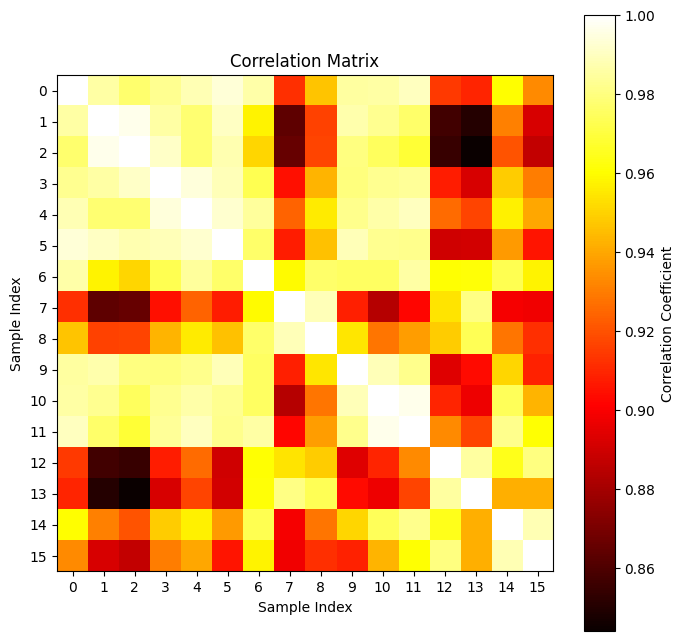

In [35]:
correlation_matrix = np.corrcoef(Ecc_aha_sample)
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.xticks(range(16))
plt.yticks(range(16))
plt.show()

In [36]:
correlation_matrix.shape

(16, 16)